# Big Data Processing and Machine Learning using PySpark

#### Importation of Required Libraries
We're importing the following libraries for the project: Pyspark, Matplotlib, Seaborn, ...

Note: I am using Pycharm environment, so the environment is setup and doesn't need installation.


## **Sections Covered**
- **1️⃣ Importing Required Libraries**
- **2️⃣ Initializing Spark Session**
- **3️⃣ Loading and Preprocessing Data**
- **4️⃣ Data Quality Checks**
- **5️⃣ Data Transformation and Feature Engineering**
- **6️⃣ Business Questions and Exploratory Analysis**
- **7️⃣ Machine Learning Implementation (Classification)**
- **8️⃣ Model Optimization (Hyperparameter Tuning)**
- **9️⃣ Model Evaluation and Comparison**

### Importing Required Libraries

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import expr, sum
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import sum
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Initializing Spark Session


In [50]:
# Initialize Spark Session
spark = SparkSession.builder.appName("DataMerge").getOrCreate()

# Verify Spark session creation by performing a simple operation
try:
    # Try creating a simple DataFrame and show it
    test_df = spark.range(2)  # Create a DataFrame with numbers 0 to 1
    test_df.show()  # Display the DataFrame
    print("Spark session is working and operational!")
except Exception as e:
    print(f"Error while verifying Spark session: {e}")

+---+
| id|
+---+
|  0|
|  1|
+---+

Spark session is working and operational!


## Loading and Preprocessing Data
This section will focus on loading the following datasets: <b>DimProduct.csv, FactInternetSales.csv, DimCustomer.csv, DimProductCategory.csv, DimProductSubCategory.csv, DimDate.csv, DimSalesTerritory.csv, </b> for our processing and analysis.

In [51]:
# File paths
files = {
    "DimProduct": "Dataset/DimProduct.csv",
    "FactInternetSales": "Dataset/FactInternetSales.csv",
    "DimCustomer": "Dataset/DimCustomer.csv",
    "DimProductCategory": "Dataset/DimProductCategory.csv",
    "DimProductSubcategory": "Dataset/DimProductSubcategory.csv",
    "DimSalesTerritory": "Dataset/DimSalesTerritory.csv",
    "DimDate": "Dataset/DimDate.csv",
}

# Load datasets
datasets = {name: spark.read.csv(path, header=True, inferSchema=True) for name, path in files.items()}

### Display Schema
Checking the structure of each schema by verifying column names and data types to spot unexpected inconsistencies

In [52]:
# Displaying the schema for all datasets
for name, df in datasets.items():
    print(f"Schema for {name}:")
    df.printSchema()
    print("\n" + "="*50 + "\n")


Schema for DimProduct:
root
 |-- ProductKey: integer (nullable = true)
 |-- ProductAlternateKey: string (nullable = true)
 |-- ProductSubcategoryKey: integer (nullable = true)
 |-- WeightUnitMeasureCode: string (nullable = true)
 |-- SizeUnitMeasureCode: string (nullable = true)
 |-- EnglishProductName: string (nullable = true)
 |-- SpanishProductName: string (nullable = true)
 |-- FrenchProductName: string (nullable = true)
 |-- StandardCost: double (nullable = true)
 |-- FinishedGoodsFlag: boolean (nullable = true)
 |-- Color: string (nullable = true)
 |-- SafetyStockLevel: integer (nullable = true)
 |-- ReorderPoint: integer (nullable = true)
 |-- ListPrice: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- SizeRange: string (nullable = true)
 |-- Weight: double (nullable = true)
 |-- DaysToManufacture: integer (nullable = true)
 |-- ProductLine: string (nullable = true)
 |-- DealerPrice: double (nullable = true)
 |-- Class: string (nullable = true)
 |-- Style: strin

#### Data Quality Checks

In [53]:
# Standardizing Column Names to Snake Case
# Function to convert column names to snake_case
def standardize_column_names(df):
    for col_name in df.columns:
        new_col_name = col_name[0].lower() + "".join(["_" + c.lower() if c.isupper() else c for c in col_name[1:]])
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

# Apply column renaming to all datasets
datasets = {name: standardize_column_names(df) for name, df in datasets.items()}

# Verify column name updates
for name, df in datasets.items():
    print(f"Updated columns in {name}: {df.columns}")


Updated columns in DimProduct: ['product_key', 'product_alternate_key', 'product_subcategory_key', 'weight_unit_measure_code', 'size_unit_measure_code', 'english_product_name', 'spanish_product_name', 'french_product_name', 'standard_cost', 'finished_goods_flag', 'color', 'safety_stock_level', 'reorder_point', 'list_price', 'size', 'size_range', 'weight', 'days_to_manufacture', 'product_line', 'dealer_price', 'class', 'style', 'model_name', 'english_description', 'start_date', 'end_date', 'status']
Updated columns in FactInternetSales: ['product_key', 'order_date_key', 'due_date_key', 'ship_date_key', 'customer_key', 'promotion_key', 'currency_key', 'sales_territory_key', 'sales_order_number', 'sales_order_line_number', 'revision_number', 'order_quantity', 'unit_price', 'extended_amount', 'unit_price_discount_pct', 'discount_amount', 'product_standard_cost', 'total_product_cost', 'sales_amount', 'tax_amt', 'freight', 'carrier_tracking_number', 'customer_p_o_number', 'order_date', 'due_

#### Checking to see if there's Key Column Names Match in Datasets

In [54]:
key_columns = {
    "FactInternetSales": ["product_key", "customer_key", "order_date_key", "sales_territory_key"],
    "DimProduct": ["product_key", "product_subcategory_key"],
    "DimProductSubcategory": ["product_subcategory_key", "product_category_key"],
    "DimProductCategory": ["product_category_key"],
    "DimCustomer": ["customer_key"],
    "DimSalesTerritory": ["sales_territory_key"],
    "DimDate": ["date_key"]
}

# Print key column names for verification
for dataset, keys in key_columns.items():
    print(f"Checking keys in {dataset}:")
    for key in keys:
        if key in datasets[dataset].columns:
            print(f"{key} exists in {dataset}")
        else:
            print(f"{key} is MISSING in {dataset}!")
    print("\n" + "="*50 + "\n")


Checking keys in FactInternetSales:
product_key exists in FactInternetSales
customer_key exists in FactInternetSales
order_date_key exists in FactInternetSales
sales_territory_key exists in FactInternetSales


Checking keys in DimProduct:
product_key exists in DimProduct
product_subcategory_key exists in DimProduct


Checking keys in DimProductSubcategory:
product_subcategory_key exists in DimProductSubcategory
product_category_key exists in DimProductSubcategory


Checking keys in DimProductCategory:
product_category_key exists in DimProductCategory


Checking keys in DimCustomer:
customer_key exists in DimCustomer


Checking keys in DimSalesTerritory:
sales_territory_key exists in DimSalesTerritory


Checking keys in DimDate:
date_key exists in DimDate




#### Checking to see if Key Columns have the same data type

In [55]:
# Check data types of key columns in each dataset
for dataset, keys in key_columns.items():
    print(f"Checking data types in {dataset}:")
    datasets[dataset].select(keys).printSchema()
    print("\n" + "="*50 + "\n")


Checking data types in FactInternetSales:
root
 |-- product_key: integer (nullable = true)
 |-- customer_key: integer (nullable = true)
 |-- order_date_key: integer (nullable = true)
 |-- sales_territory_key: integer (nullable = true)



Checking data types in DimProduct:
root
 |-- product_key: integer (nullable = true)
 |-- product_subcategory_key: integer (nullable = true)



Checking data types in DimProductSubcategory:
root
 |-- product_subcategory_key: integer (nullable = true)
 |-- product_category_key: integer (nullable = true)



Checking data types in DimProductCategory:
root
 |-- product_category_key: integer (nullable = true)



Checking data types in DimCustomer:
root
 |-- customer_key: integer (nullable = true)



Checking data types in DimSalesTerritory:
root
 |-- sales_territory_key: integer (nullable = true)



Checking data types in DimDate:
root
 |-- date_key: integer (nullable = true)





#### Checking for Null values in key columns

In [56]:
# Check for NULL values in key columns
for dataset, keys in key_columns.items():
    print(f"Checking for NULL values in {dataset}:")
    for key in keys:
        null_count = datasets[dataset].filter(col(key).isNull()).count()
        print(f"{key} has {null_count} NULL values in {dataset}")
    print("\n" + "="*50 + "\n")


Checking for NULL values in FactInternetSales:
product_key has 0 NULL values in FactInternetSales
customer_key has 0 NULL values in FactInternetSales
order_date_key has 0 NULL values in FactInternetSales
sales_territory_key has 0 NULL values in FactInternetSales


Checking for NULL values in DimProduct:
product_key has 0 NULL values in DimProduct
product_subcategory_key has 0 NULL values in DimProduct


Checking for NULL values in DimProductSubcategory:
product_subcategory_key has 0 NULL values in DimProductSubcategory
product_category_key has 0 NULL values in DimProductSubcategory


Checking for NULL values in DimProductCategory:
product_category_key has 0 NULL values in DimProductCategory


Checking for NULL values in DimCustomer:
customer_key has 0 NULL values in DimCustomer


Checking for NULL values in DimSalesTerritory:
sales_territory_key has 0 NULL values in DimSalesTerritory


Checking for NULL values in DimDate:
date_key has 0 NULL values in DimDate




### Data Transformation (Joining the Our Datasets)

In [57]:
# Start with the fact table
fact_sales = datasets["FactInternetSales"]

# Join FactInternetSales with DimProduct
fact_sales = fact_sales.join(datasets["DimProduct"], "product_key", "left")

# Join FactInternetSales with DimCustomer
fact_sales = fact_sales.join(datasets["DimCustomer"], "customer_key", "left")

# Join FactInternetSales with DimDate
fact_sales = fact_sales.join(datasets["DimDate"], fact_sales.order_date_key == datasets["DimDate"].date_key, "left").drop("date_key")

# Join FactInternetSales with DimSalesTerritory
fact_sales = fact_sales.join(datasets["DimSalesTerritory"], "sales_territory_key", "left")

# Join DimProduct with DimProductSubcategory
dim_product = datasets["DimProduct"].join(datasets["DimProductSubcategory"], "product_subcategory_key", "left")

# Join DimProductSubcategory with DimProductCategory
dim_product = dim_product.join(datasets["DimProductCategory"], "product_category_key", "left")

# Display final merged fact_sales dataset
fact_sales.show(10)


+-------------------+------------+-----------+--------------+------------+-------------+-------------+------------+------------------+-----------------------+---------------+--------------+----------+---------------+-----------------------+---------------+---------------------+------------------+------------+--------+-------+-----------------------+-------------------+-------------------+-------------------+-------------------+---------------------+-----------------------+------------------------+----------------------+--------------------+--------------------+--------------------+-------------+-------------------+------+------------------+-------------+----------+----+----------+------+-------------------+------------+------------+-----+-----+------------+--------------------+----------------+----------------+------+-------------+----------------------+-----+----------+-----------+---------+----------+----------+--------------+------+------+--------------------+-------------+---------

## Data quality checks and data cleaning process

#### Checking row count check before and after joining

In [58]:
# Check row count before and after joining
fact_sales_count = datasets["FactInternetSales"].count()
merged_fact_sales_count = fact_sales.count()

print(f"FactInternetSales before join: {fact_sales_count} rows")
print(f"Merged dataset after join: {merged_fact_sales_count} rows")


FactInternetSales before join: 60398 rows
Merged dataset after join: 60398 rows


#### Check for duplicate rows

In [59]:
# Check for duplicate rows
duplicate_count = fact_sales.groupBy(fact_sales.columns).count().filter("count > 1").count()
print(f"Duplicate rows in merged dataset: {duplicate_count}")

Duplicate rows in merged dataset: 0


#### Check for NULL Values in Important Columns

In [60]:

# List of important columns to check
important_columns = ["product_key", "customer_key", "order_date_key", "sales_territory_key", "sales_amount"]

# Check for NULL values in important columns
for col_name in important_columns:
    null_count = fact_sales.filter(col(col_name).isNull()).count()
    print(f"{col_name} has {null_count} NULL values")

product_key has 0 NULL values
customer_key has 0 NULL values
order_date_key has 0 NULL values
sales_territory_key has 0 NULL values
sales_amount has 0 NULL values


#### Check for Duplicate Rows

In [61]:
fact_sales.select("order_quantity", "unit_price", "sales_amount", "tax_amt", "freight").describe().show()

+-------+--------------+-----------------+-----------------+-----------------+------------------+
|summary|order_quantity|       unit_price|     sales_amount|          tax_amt|           freight|
+-------+--------------+-----------------+-----------------+-----------------+------------------+
|  count|         60398|            60398|            60398|            60398|             60398|
|   mean|           1.0|486.0869105053777|486.0869105053777|38.88695370873952|12.152217111493709|
| stddev|           0.0| 928.489891980807| 928.489891980807|74.27919255248155|23.212248232767838|
|    min|             1|             2.29|             2.29|           0.1832|            0.0573|
|    max|             1|          3578.27|          3578.27|         286.2616|           89.4568|
+-------+--------------+-----------------+-----------------+-----------------+------------------+



## Business Questions & Exploratory Analysis

#### Sales and Product Analysis

1. 	Which products generate the highest sales revenue and profit margins?
2.	How does product performance vary across different categories and subcategories?
3.	How do sales trends vary across different sales territories?
4.	How does customer income level impact total sales?
5.	Which occupations contribute the most to total sales?"
6.	How does customer income level influence product category preference?


#### Which products generate the highest sales revenue and profit margins?


In [62]:
# Aggregating total sales revenue and profit margins for each product to identify the highest-grossing and most profitable products.

product_analysis = fact_sales.groupBy("english_product_name") \
    .agg(
        sum("sales_amount").alias("total_sales"),
        sum(expr("sales_amount - total_product_cost")).alias("profit_margin")
    ) \
    .orderBy("total_sales", ascending=False)

product_analysis.show(10)

+--------------------+------------------+------------------+
|english_product_name|       total_sales|     profit_margin|
+--------------------+------------------+------------------+
|Mountain-200 Blac...|1373469.5481999982| 626621.5735000019|
|Mountain-200 Blac...| 1363142.093399998| 621759.6083000018|
|Mountain-200 Silv...| 1339462.790399998| 610864.4347999995|
|Mountain-200 Silv...|1301100.0983999984| 593490.4727999989|
|Mountain-200 Blac...| 1294866.141199998| 590477.4604000015|
|Mountain-200 Silv...| 1257434.572799998| 573511.9375999994|
|    Road-150 Red, 48|1205876.9900000044|474150.84460000356|
|    Road-150 Red, 62|1202298.7200000044|472743.86880000355|
|    Road-150 Red, 52|1080637.5400000038|424906.69160000305|
|    Road-150 Red, 56|1055589.6500000036|415057.86100000294|
+--------------------+------------------+------------------+
only showing top 10 rows



In [63]:
 # Calculate total sales for all products
total_sales = fact_sales.agg(sum("sales_amount").alias("total_sales")).collect()[0]["total_sales"]

# Calculate total sales for Mountain-200 Black and Mountain-200 Silver
mountain_sales = fact_sales.filter(
    (col("english_product_name").like("Mountain-200 Black%")) |
    (col("english_product_name").like("Mountain-200 Silver%"))
).agg(sum("sales_amount").alias("mountain_total_sales")).collect()[0]["mountain_total_sales"]

# Calculate the percentage contribution
percentage_contribution = (mountain_sales / total_sales) * 100

# Display result
print(f"Mountain-200 Black & Silver contribute {percentage_contribution:.2f}% to total revenue.")


Mountain-200 Black & Silver contribute 27.01% to total revenue.


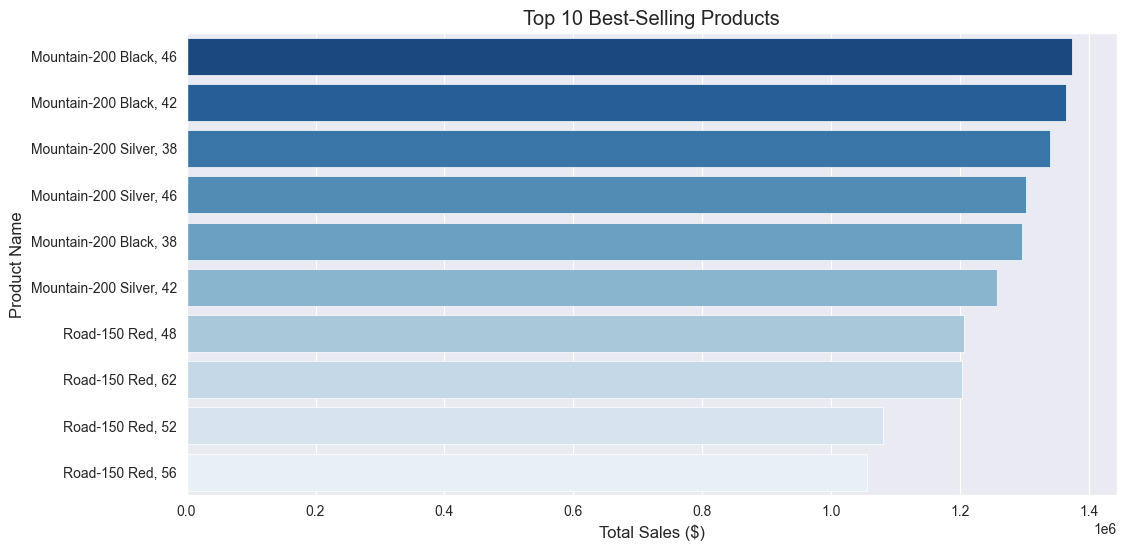

In [64]:
#Top-Selling Products (Bar Chart)
# Convert to Pandas
product_sales_df = product_analysis.limit(10).toPandas()

# Plot Top-Selling Products
plt.figure(figsize=(12, 6))
sns.barplot(
    x="total_sales",
    y="english_product_name",
    data=product_sales_df,
    hue="english_product_name",  # Assign hue to the y-axis variable
    dodge=False,                 # Prevent bars from being split
    legend=False,                 # Remove redundant legend
    palette="Blues_r"
)
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Name")
plt.title("Top 10 Best-Selling Products")
plt.show()

<b>Insight:</b> The top-selling products are Mountain-200 Black and Mountain-200 Silver, contributing the highest sales revenue of 27.01%. These products also show strong profit margins, indicating their profitability.

### How does product performance vary across different categories and subcategories?

In [65]:
# Join FactInternetSales with DimProduct to associate sales data with product details
fact_sales_with_product = fact_sales.join(
    datasets["DimProduct"], "product_key", "inner"
)

# Join with DimProductSubcategory to include product subcategory information
fact_sales_with_subcategory = fact_sales_with_product.join(
    datasets["DimProductSubcategory"], "product_subcategory_key", "inner"
)

# Join with DimProductCategory to associate each product with its category
fact_sales_with_category = fact_sales_with_subcategory.join(
    datasets["DimProductCategory"], "product_category_key", "inner"
)

# Aggregate sales and profit margin at the category level
category_analysis = fact_sales_with_category.groupBy("english_product_category_name") \
    .agg(
        sum("sales_amount").alias("total_sales"),
        sum(expr("sales_amount - total_product_cost")).alias("profit_margin")
    ) \
    .orderBy("total_sales", ascending=False)



# Aggregate sales and profit margin at the subcategory level
subcategory_analysis = fact_sales_with_subcategory.groupBy("english_product_subcategory_name") \
    .agg(
        sum("sales_amount").alias("total_sales"),
        sum(expr("sales_amount - total_product_cost")).alias("profit_margin")
    ) \
    .orderBy("total_sales", ascending=False)


category_analysis.show()
subcategory_analysis.show()

+-----------------------------+--------------------+--------------------+
|english_product_category_name|         total_sales|       profit_margin|
+-----------------------------+--------------------+--------------------+
|                        Bikes|2.8318144650701128E7|1.1505796500600025E7|
|                  Accessories|   700759.9599999422|  438674.56809997605|
|                     Clothing|   339772.6100000149|  136412.57629999678|
+-----------------------------+--------------------+--------------------+

+--------------------------------+--------------------+------------------+
|english_product_subcategory_name|         total_sales|     profit_margin|
+--------------------------------+--------------------+------------------+
|                      Road Bikes|1.4520584036299847E7| 5537299.698599855|
|                  Mountain Bikes|   9952759.564400222| 4513624.106100044|
|                   Touring Bikes|  3844801.0500000035| 1454872.695899993|
|                 Tires and Tub

#### Which product categories generate the highest sales?

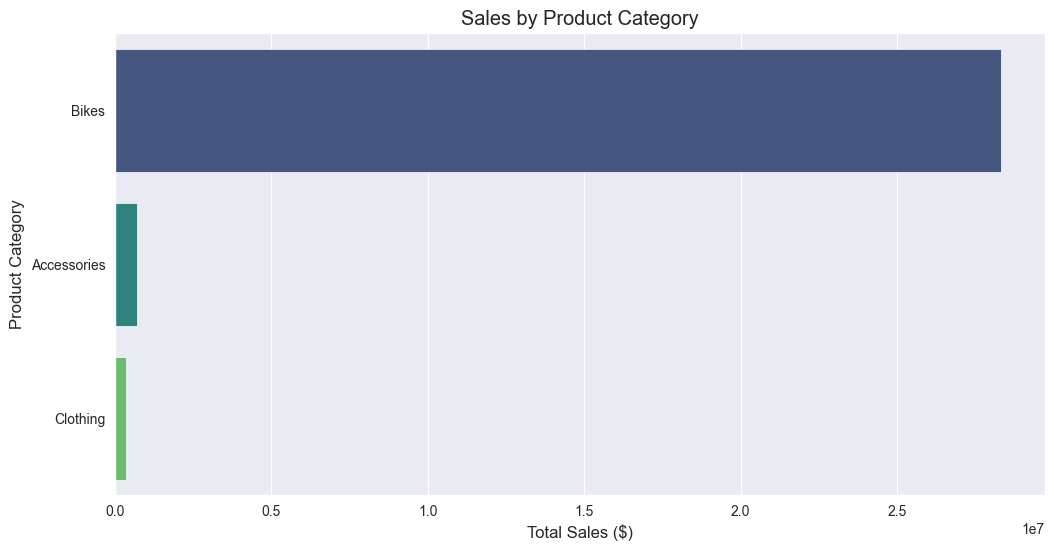

In [66]:
# Convert category sales data to Pandas for visualization
category_sales_df = category_analysis.toPandas()

# Plot total sales by product category
plt.figure(figsize=(12, 6))
sns.barplot(
    x="total_sales",
    y="english_product_category_name",
    data=category_sales_df,
    hue="english_product_category_name",  # Assign hue to the y-axis variable
    dodge=False,                           # Prevent bars from being split
    legend=False,                          # Remove redundant legend
    palette="viridis"
)
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Category")
plt.title("Sales by Product Category")
plt.show()

#### Which product subcategories generate the highest sales?

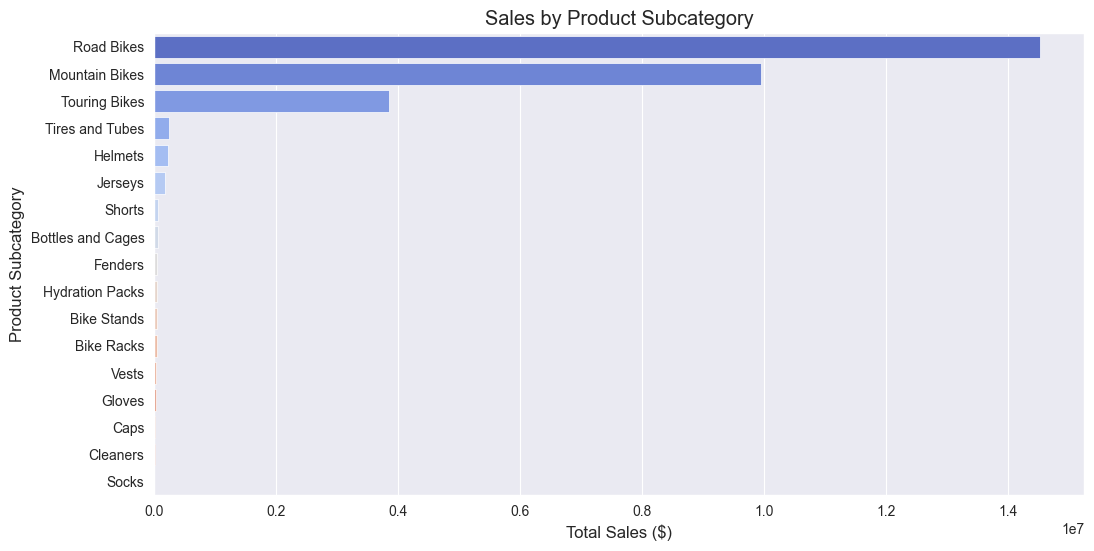

In [67]:
# Convert subcategory sales data to Pandas for visualization
subcategory_sales_df = subcategory_analysis.toPandas()

# Plot total sales by product subcategory
plt.figure(figsize=(12, 6))
sns.barplot(
    x="total_sales",
    y="english_product_subcategory_name",
    data=subcategory_sales_df,
    hue="english_product_subcategory_name",  # Assign hue to the y-axis variable
    dodge=False,                             # Prevent bars from being split
    legend=False,                            # Remove redundant legend
    palette="coolwarm"
)
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Subcategory")
plt.title("Sales by Product Subcategory")
plt.show()

<b>Insight:</b> Bikes generate the highest sales and profit margin, outperforming other product categories. Within the subcategories, Road Bikes and Mountain Bikes are the top contributors to sales. Accessories and Clothing have lower sales and profit margins.

### How Do Sales Trends Vary Across Different Sales Territories?



In [68]:
#Analyze Sales by Territory

territory_sales = fact_sales.groupBy("sales_territory_group") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

territory_sales.show()

+---------------------+--------------------+
|sales_territory_group|         total_sales|
+---------------------+--------------------+
|        North America|1.1367634372902095E7|
|              Pacific|   9061000.584400563|
|               Europe|   8930042.263400966|
+---------------------+--------------------+



#### Sales Distribution Across Territories

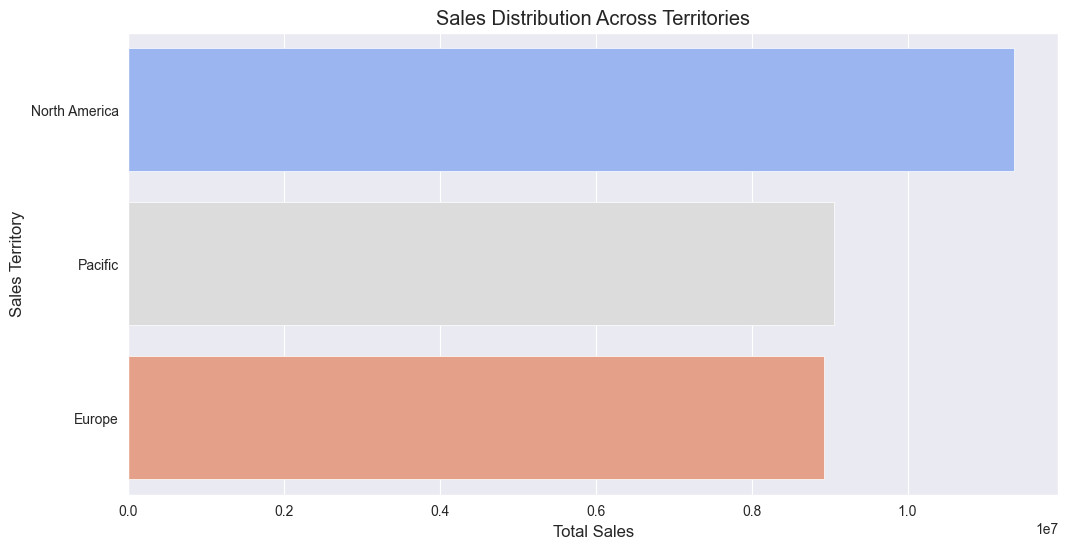

In [69]:
# Aggregate sales by sales territory
territory_sales = fact_sales.groupBy("sales_territory_group") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

# Convert to Pandas for visualization
territory_sales_df = territory_sales.toPandas()

# Plot Sales by Territory
plt.figure(figsize=(12, 6))
sns.barplot(x="total_sales", y="sales_territory_group", data=territory_sales_df, hue="sales_territory_group", dodge=False, legend=False, palette="coolwarm")
plt.xlabel("Total Sales")
plt.ylabel("Sales Territory")
plt.title("Sales Distribution Across Territories")
plt.show()

<b>Insight:<b/> The analysis shows that North America has the highest total sales, followed by the Pacific and Europe. This indicates that sales performance is strongest in North America, suggesting a larger market presence or demand in this region. Marketing efforts and inventory distribution can be strategized.

### How does customer income level impact total sales?

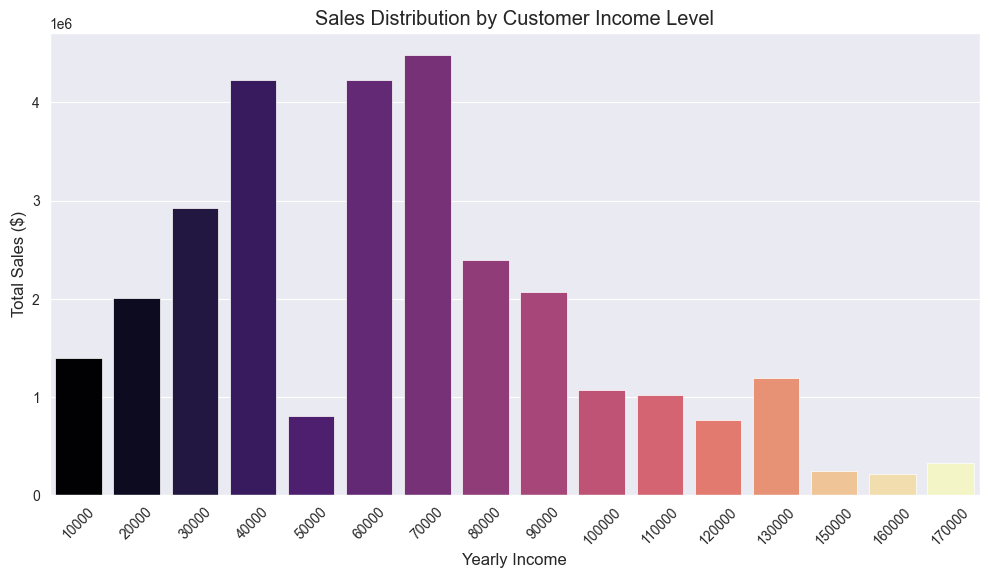

In [70]:
customer_sales = fact_sales.groupBy("yearly_income") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

customer_sales_df = customer_sales.toPandas()

# Bar Plot for Customer Income vs. Sales
plt.figure(figsize=(12, 6))
sns.barplot(x="yearly_income", y="total_sales", data=customer_sales_df, hue="yearly_income", palette="magma", legend=False)
plt.xlabel("Yearly Income")
plt.ylabel("Total Sales ($)")
plt.title("Sales Distribution by Customer Income Level")
plt.xticks(rotation=45)
plt.show()



<b>Insight:</b> The middle-income customers earning between $40,000 and $70,000 generate the highest sales, while both lower and higher-income groups contribute significantly less. This suggests that the sales optimisation should target the mid-range income earners.

### Which occupations contribute the most to total sales?"

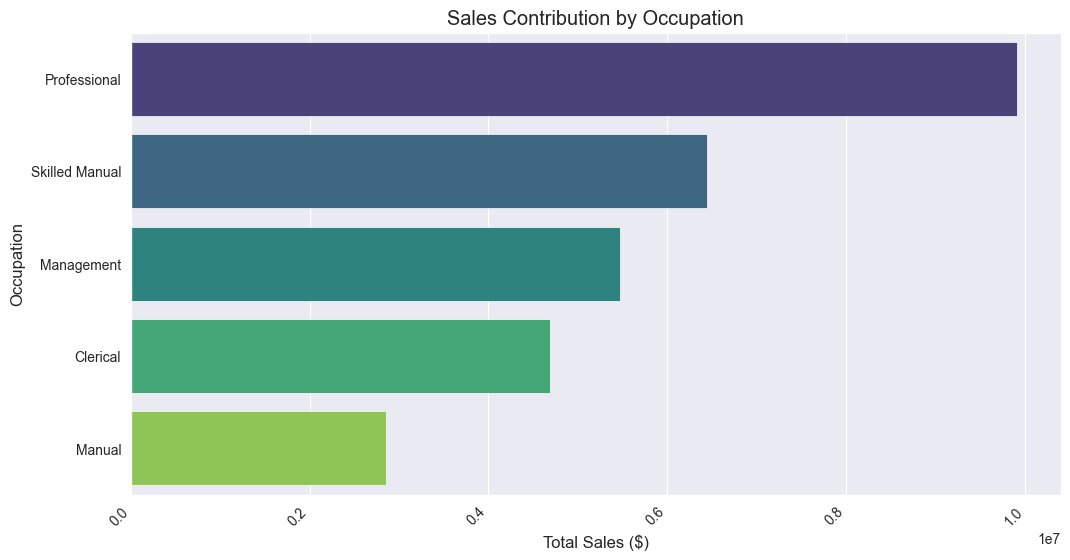

In [71]:
# Aggregate total sales by occupation
occupation_sales = fact_sales.groupBy("english_occupation") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("total_sales", ascending=False)

# Convert to Pandas for visualization
occupation_sales_df = occupation_sales.toPandas()

# Bar Chart for Sales by Occupation
plt.figure(figsize=(12, 6))
sns.barplot(x="total_sales", y="english_occupation", data=occupation_sales_df, hue="english_occupation", dodge=False, palette="viridis", legend=False)
plt.xlabel("Total Sales ($)")
plt.ylabel("Occupation")
plt.title("Sales Contribution by Occupation")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()



<b>Insight:</b> The highest sales revenue is contributed by professionals, followed by skilled manual and management occupations. This suggests that targeting professionals with premium products or specialised marketing campaigns could be beneficial for the revenue growth of the business.

### How does customer income level influence product category preference?

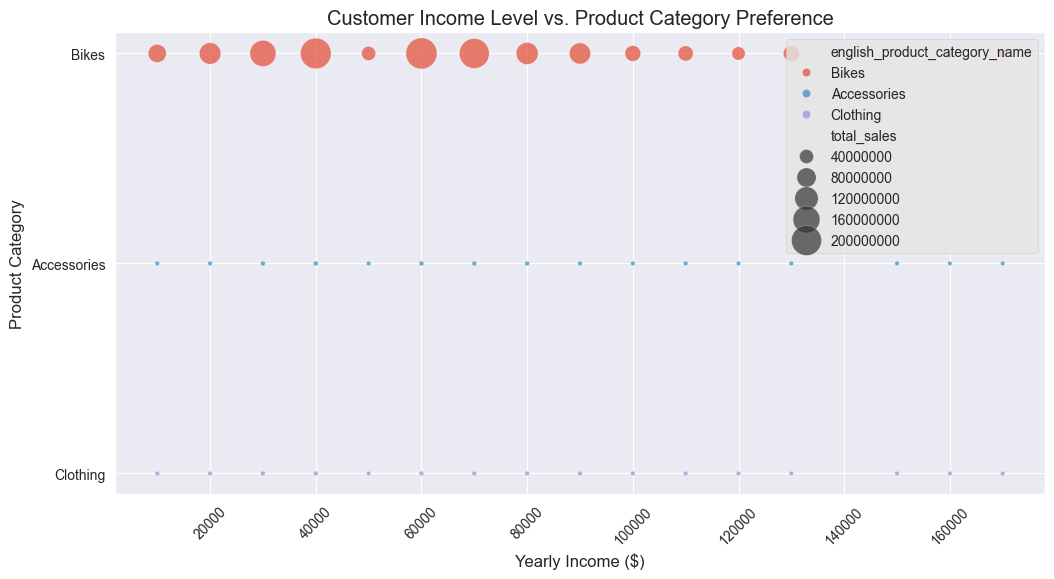

In [72]:
# Join the result with DimProductCategory
fact_sales_with_category = fact_sales.join(dim_product, "product_subcategory_key", "left")

# Aggregate total sales by income level and product category
income_category_sales = fact_sales_with_category.groupBy("yearly_income", "english_product_category_name") \
    .agg(sum("sales_amount").alias("total_sales")) \
    .orderBy("yearly_income", ascending=True)

# Convert to Pandas
income_category_sales_df = income_category_sales.toPandas()

# Scatter Plot: Income vs. Product Category Sales
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
plt.style.use("ggplot")  # or "seaborn-whitegrid"
sns.scatterplot(x="yearly_income", y="english_product_category_name", size="total_sales",
                hue="english_product_category_name", data=income_category_sales_df,
                sizes=(10, 500), alpha=0.7)
plt.xlabel("Yearly Income ($)")
plt.ylabel("Product Category")
plt.title("Customer Income Level vs. Product Category Preference")
plt.grid(True)
plt.show()


<b>Insight:</b> Suggests that customer income level significantly influences product category preference. Higher-income customers tend to purchase premium products, while lower to mid-income customers contribute more to essential or budget-friendly categories.

#### Advanced Visualization

In [ ]:
import plotly.express as px

# Create an interactive scatter plot
fig = px.scatter(df, x="sales_amount", y="profit_margin", color="product_category", size="order_quantity")
fig.show()

# Machine Learning Predictions

### Predicting Product Categories for Future Purchases (Classification)


In [93]:
# Load and prepare dataset
fact_sales_with_category = fact_sales.join(dim_product, "product_key")
labeled_data = fact_sales_with_category.select(
    "customer_key", "sales_territory_group", "order_quantity", "sales_amount", "freight", "english_product_category_name"
)

In [94]:
# Convert category name to numerical labels
indexer = StringIndexer(inputCol="english_product_category_name", outputCol="label")
labeled_data = indexer.fit(labeled_data).transform(labeled_data)
labeled_data.show()

+------------+---------------------+--------------+------------+-------+-----------------------------+-----+
|customer_key|sales_territory_group|order_quantity|sales_amount|freight|english_product_category_name|label|
+------------+---------------------+--------------+------------+-------+-----------------------------+-----+
|       25086|        North America|             1|       24.49| 0.6123|                     Clothing|  2.0|
|       19225|        North America|             1|        63.5| 1.5875|                     Clothing|  2.0|
|       23105|              Pacific|             1|       24.49| 0.6123|                     Clothing|  2.0|
|       16944|               Europe|             1|       24.49| 0.6123|                     Clothing|  2.0|
|       29356|               Europe|             1|        63.5| 1.5875|                     Clothing|  2.0|
|       28207|              Pacific|             1|        63.5| 1.5875|                     Clothing|  2.0|
|       22432|     

In [98]:
labeled_data.describe()

DataFrame[summary: string, customer_key: string, sales_territory_group: string, order_quantity: string, sales_amount: string, freight: string, english_product_category_name: string, label: string]

In [103]:
# Assemble features
feature_cols = ["order_quantity", "sales_amount", "freight"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
labeled_data = assembler.transform(labeled_data)


In [76]:
# Train-Test Split
train_data, test_data = labeled_data.randomSplit([0.8, 0.2], seed=42)


In [105]:

# Train and evaluate models
def train_and_evaluate(model, train_data, test_data):
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    return model_trained, predictions, accuracy


In [87]:
rf_model, rf_predictions, rf_accuracy = train_and_evaluate(RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100), train_data, test_data)
lr_model, lr_predictions, lr_accuracy = train_and_evaluate(LogisticRegression(featuresCol="features", labelCol="label", maxIter=100), train_data, test_data)
nb_model, nb_predictions, nb_accuracy = train_and_evaluate(NaiveBayes(featuresCol="features", labelCol="label"), train_data, test_data)


In [88]:
# Display model accuracies
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Naïve Bayes Accuracy: {nb_accuracy}")


Random Forest Accuracy: 0.947139813145386
Logistic Regression Accuracy: 0.8571545648254385
Naïve Bayes Accuracy: 0.839944271430913


In [106]:
# Define evaluators for different metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")


f1_score = evaluator_f1.evaluate(rf_predictions)
precision = evaluator_precision.evaluate(rf_predictions)
recall = evaluator_recall.evaluate(rf_predictions)

print(f"F1-Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1-Score: 0.9473441362754716
Precision: 0.9475840282200609
Recall: 0.947139813145386


In [107]:
# Confusion Matrix for Best Model
best_model_predictions = rf_predictions  # Assume RF performed best
predictions_pd = best_model_predictions.select("label", "prediction").toPandas()
conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])


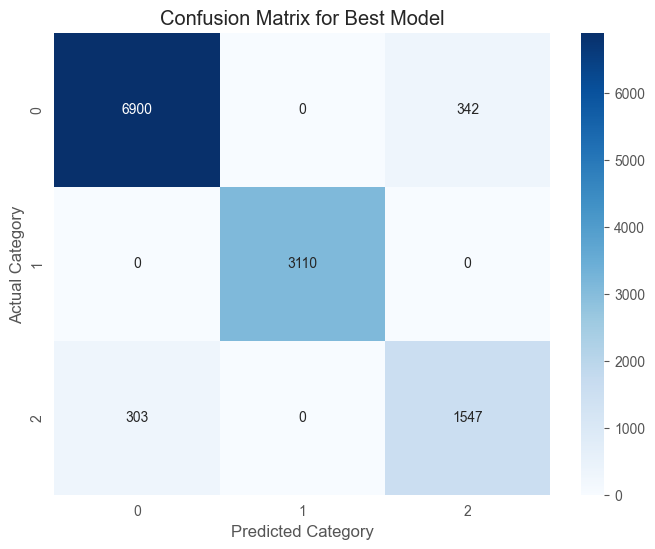

In [108]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Best Model")
plt.show()


In [82]:
# Feature Importance (Random Forest)
feature_importances = rf_model.featureImportances.toArray()
feature_names = ["order_quantity", "sales_amount", "freight"]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)


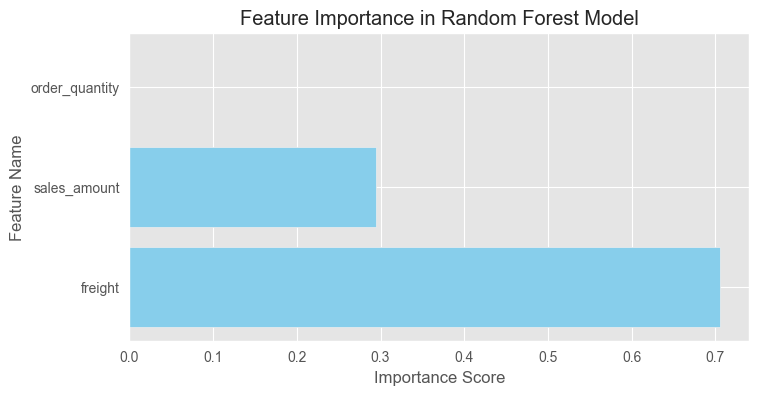

In [83]:
plt.figure(figsize=(8, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Random Forest Model")
plt.show()


In [84]:
# Hyperparameter Tuning for Random Forest
paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [50, 100, 150]) \
    .addGrid(rf_model.maxDepth, [5, 10, 15]) \
    .build()

crossval = CrossValidator(
    estimator=RandomForestClassifier(featuresCol="features", labelCol="label"),
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    numFolds=3
)

In [90]:
cv_model = crossval.fit(train_data)
cv_predictions = cv_model.transform(test_data)
cv_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(cv_predictions)
print(f"Tuned Random Forest Accuracy: {cv_accuracy}")


Tuned Random Forest Accuracy: 0.947139813145386


In [109]:
# Define evaluators for different metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Evaluate Tuned Model
tuned_f1_score = evaluator_f1.evaluate(cv_predictions)
tuned_precision = evaluator_precision.evaluate(cv_predictions)
tuned_recall = evaluator_recall.evaluate(cv_predictions)

# Print Results
print(f"Tuned Random Forest F1-Score: {tuned_f1_score}")
print(f"Tuned Random Forest Precision: {tuned_precision}")
print(f"Tuned Random Forest Recall: {tuned_recall}")


Tuned Random Forest F1-Score: 0.9473441362754716
Tuned Random Forest Precision: 0.9475840282200609
Tuned Random Forest Recall: 0.947139813145386


### Future Work:
While the Random Forest model performed well, exploring advanced models such as Gradient Boosting (e.g., XGBoost, LightGBM), Deep Learning models (LSTMs, RNNs for sequential sales data), or AutoML approaches may further enhance predictive accuracy. Thank You!

### Advanced Machine Learning Models: Gradient Boosting Model (XGBoost)

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Evaluate model
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy}")

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_}")